In [3]:
%matplotlib inline

import zipline
from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import numpy as np 

from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import FixedSlippage, VolatilityVolumeShare

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 20000000
vola_window = 40
slow_ma = 80
fast_ma = 40
risk_factor = 0.0015
high_window = 20
days_to_hold = 20
dip_buy = -3

def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

def initialize(context):
    """
    Cost Settings
    """
    context.enable_commission = True
    context.enable_slippage = True   
    
    if context.enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)
    
    if context.enable_slippage:
        slippage_model=VolatilityVolumeShare(volume_limit=0.3)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(us_futures=slippage_model)
    
    agricultural = [
        'BL', 
        'CC',
        'CT',
        'FC',
        'KC',
        'LB',
        'LR',
        'OJ',
        'RR',
        '_S',
        'SB',
        'LC',
        'LS',
    ]
    nonagricultural = [
        'CL',
        'GC',
        'HG',
        'HO',
        'LG',
        'PA',
        'PL',
        'RB',
        'SI',
        'NG',
        'LO',
    ]
    currencies = [
        'AD',
        'BP',
        'CD',
        'CU',
        'DX',
        'NE',
        'SF',
        'JY',
    ]
    equities = [
        'ES',
        'NK',
        'NQ',
        'YM',
    ]
    rates = [
        'ED',
        'FV',
        'TU',
        'TY',
        'US',
    ]
    
    markets = agricultural + nonagricultural + currencies + equities + rates
    
    context.universe = \
        [
        continuous_future(market, offset=0, roll='volume', adjustment='mul') \
        for market in markets
        ]
    
    # Dictionary used for keeping track of how many days a position has been open.
    context.bars_held = {market.root_symbol: 0 for market in context.universe} 
    
    # Schedule daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0  
    
    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )     
    
def roll_futures(context, data):
    open_orders = zipline.api.get_open_orders()
    
    for held_contract in context.portfolio.positions:
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: 
            continue
        
        # Save some time by only checking rolls for
        # contracts expiring in the next week
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue        
        
        # Make a continuation
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )
        
        # Get the current contract of the continuation
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open new position
            order_target(continuation_contract, pos_size)
    
def position_size(portfolio_value, std, pv):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    # Return rounded down number.
    return int(np.nan_to_num(contracts))

def daily_trade(context, data):
    
    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions} 
        
    hist = data.history(
        context.universe, 
        fields=['close', 'volume'], 
        frequency='1d', 
        bar_count=250,
    )
    
    # Calculate the trend
    hist['trend'] = hist['close'].ewm(span=fast_ma).mean() > hist['close'].ewm(span=slow_ma).mean()
    
    for continuation in context.universe:
        root = continuation.root_symbol
        
        # Slice off history for this market
        h = hist.xs(continuation, 2)
        
        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()
        
        if root in open_pos: # Check open positions first.
            context.bars_held[root] += 1 # One more day held
            
            if context.bars_held[root] >= 20:
                # Held for a month, exit
                contract = open_pos[root]
                order_target(contract, 0)

            elif h['trend'].iloc[-1] == False:
                # Trend changed, exit.
                contract = open_pos[root]
                order_target(contract, 0)

        else: # Check for new entries
            if h['trend'].iloc[-1]:
                
                # Calculate the pullback
                pullback = (
                    h['close'].values[-1] - np.max(h['close'].values[-high_window:])
                    ) / std
                
                if pullback < dip_buy:
                    # Get the current contract
                    contract = data.current(continuation, 'contract')
                    
                    # Calculate size
                    contracts_to_trade = position_size( \
                                           context.portfolio.portfolio_value, \
                                           std, \
                                           contract.price_multiplier)                  
                    # Trade
                    order_target(contract, contracts_to_trade)
                    
                    # Reset bar count to zero
                    context.bars_held[root] = 0
    
    # Check if we need to roll.
    if len(open_pos) > 0:  
        roll_futures(context, data)
    
start = datetime(2001, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2018, 12, 31, 8, 15, 12, 0, pytz.UTC)

perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='futures' ) 

HTML(value='')

C:\ProgramData\Anaconda3_new\envs\zip35\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2001-01-02
End date,2018-12-31
Total months,215
,Backtest
Annual return,11.0%
Cumulative returns,550.5%
Annual volatility,18.5%
Sharpe ratio,0.66
Calmar ratio,0.36
Stability,0.95
Max drawdown,-30.1%


C:\ProgramData\Anaconda3_new\envs\zip35\lib\site-packages\numpy\core\fromnumeric.py:1033: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return argmin(axis, out)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.09,2011-07-26,2013-06-24,2014-05-14,732
1,29.40,2010-04-29,2010-05-20,2010-11-04,136
2,22.29,2008-07-11,2009-07-08,2009-09-17,310
3,20.52,2018-01-26,2018-12-31,NaT,NaN
4,20.37,2004-04-12,2004-06-29,2005-03-04,235


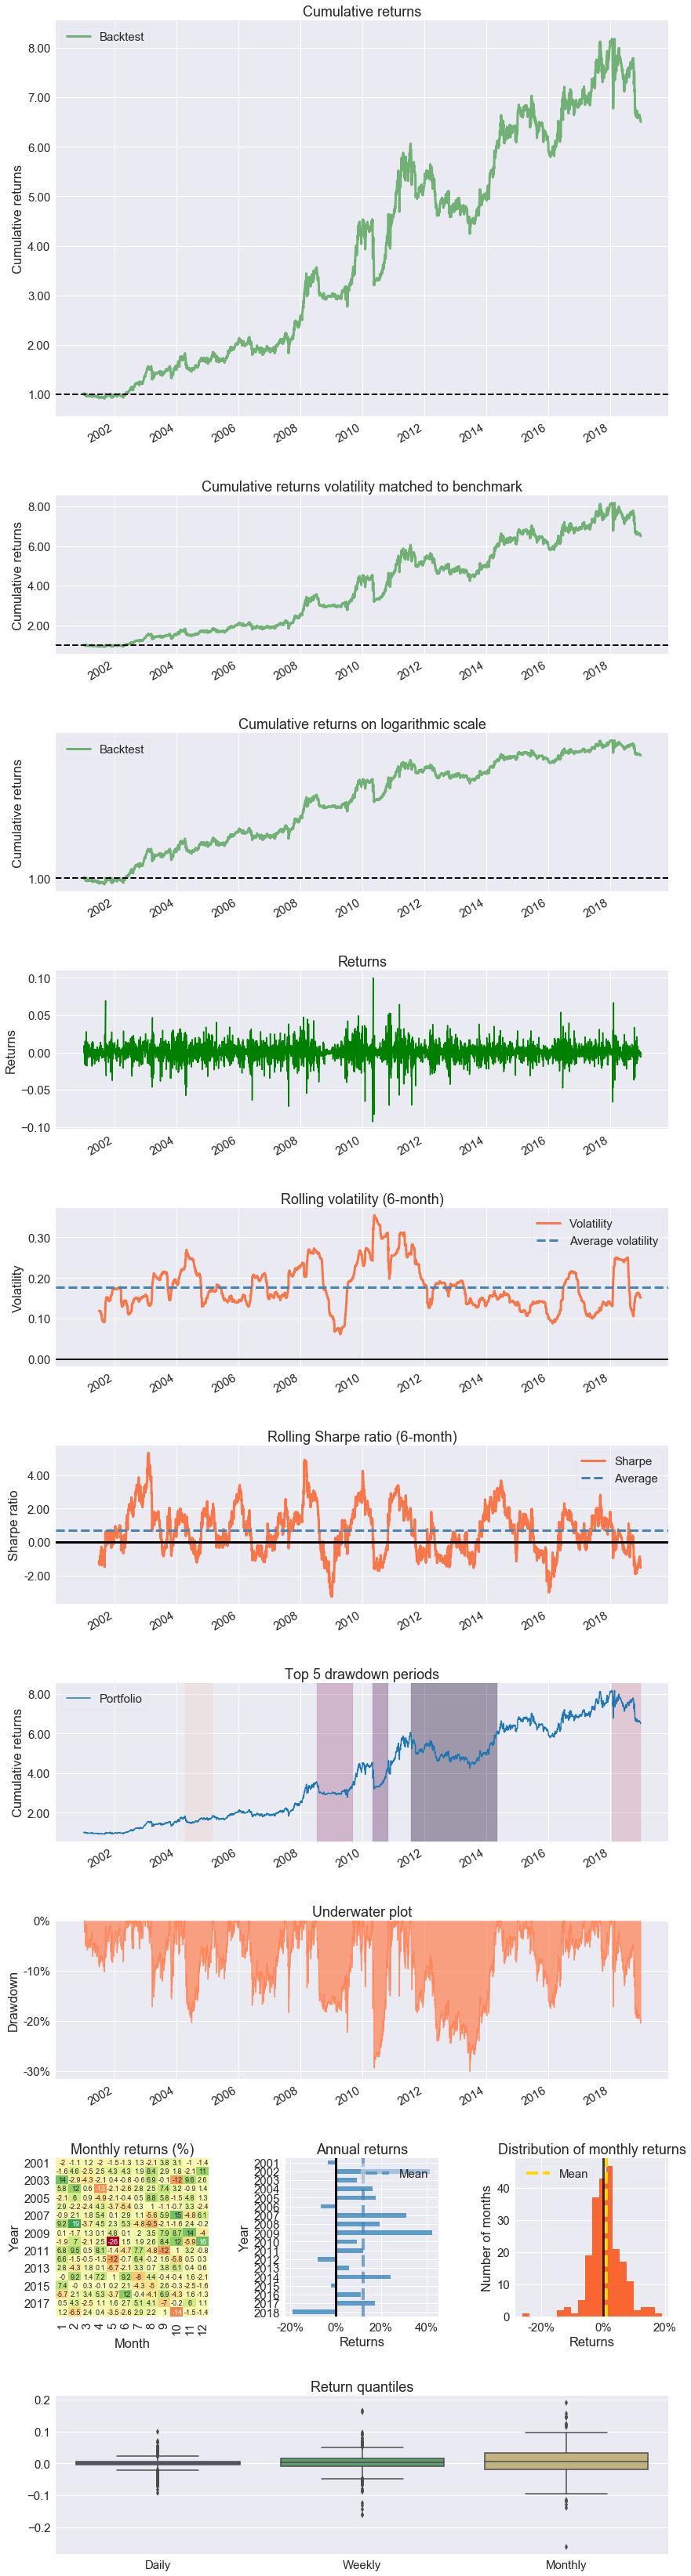

In [4]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [5]:
perf.portfolio_value.to_csv('counter_trend.csv')